# M2177.003100 Deep Learning <br> Assignment #2 Part 3: Visualizing Convolutional Neural Networks

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

In this notebook, you will learn how to visualize a convolutional neural network (CNN) pretrained to perform image classification on ImageNet dataset. <br>
There are **3 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

1. [Visualizing image-specific class saliency maps](#1) ( 10 points )
2. [Visualizing class representative images](#2) ( 10 points )
3. [Generating adversarial examples](#3) ( 10 points )

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all three parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a compressed file called *team_#.tar.gz*. Please submit this file on ETL. &nbsp;&nbsp; (Usage example: ./*CollectSubmission.sh* &nbsp; team_77)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016. [[pdf]](https://arxiv.org/pdf/1602.07360.pdf)
- [4] Simonyan et al., "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014. [[pdf]](https://arxiv.org/pdf/1312.6034.pdf)
- [5] Szegedy et al., "Intriguing properties of neural networks", ICLR 2014. [[pdf]](https://arxiv.org/pdf/1312.6199.pdf)
- [6] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)
- [7] Yosinski et al., "Understanding Neural Networks Through Deep Visualization", ICML Workshop 2015. [[pdf]](http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf)

## Load datasets and a pretrained model
The ImageNet validation dataset (which was not used in the training) and a pretrained CNN model will be downloaded automatically if it is not located in the *Utils* directory. You can use any model here, but for the purposes of this assignment you will use **SqueezeNet** [3], which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from Utils.data_utils import load_ImageNet_val, plot_images
from Utils.data_utils import random_noise_image, jitter_image, unjitter_image, blur_image
from Utils.model_utils import SqueezeNet
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.8
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

>> Downloading imagenet_val_25.npz 100.2%
Successfully downloaded and unpacked
Data shape (5, 224, 224, 3)
Labels shape (5,)


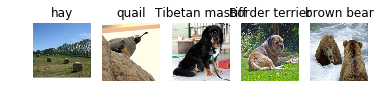

In [2]:
X, Y, Class_names = load_ImageNet_val(num=5)
print('Data shape ' + str(X.shape))
print('Labels shape ' + str(Y.shape))
plot_images(X, Y, Class_names)

In [3]:
# Clear old variables and create a session
tf.reset_default_graph()   
sess = tf.Session(config=conf)

"""
Model variables:
- model.inputs: Input images, numpy array of shape (N, H, W, 3)
- model.targets: Labels, numpy of shape (N,)
- model.outputs: Unnormalized prediction scores, numpy of shape (N, 1000)
"""
model = SqueezeNet(sess)

>> Downloading squeezenet_tf.zip 100.1%
Successfully downloaded and unpacked
INFO:tensorflow:Restoring parameters from ./Utils/squeezenet.ckpt


## <a name="1"></a> 1. Visualizing image-specific class saliency maps ( 10 points )

In this section, you will visualize image-specific class saliency maps from the pretrained model (Section 3.1 of [4]).

A **saliency map** tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape `(H, W, 3)` then this gradient will also have shape `(H, W, 3)`; for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape `(H, W)` and all entries are nonnegative.

**Complete** the implemeation of the `compute_saliency_maps` function and visualize some class saliency maps on our example images.


In [36]:
# variable check
print(model.inputs)
print(model.targets)
print(model.outputs)
np.arange(len(Y))

Tensor("input_image:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("labels:0", shape=(?,), dtype=int32)
Tensor("classifier/Reshape:0", shape=(?, 1000), dtype=float32)


array([0, 1, 2, 3, 4])

(5, 224, 224, 3) (5,) (5, 224, 224)


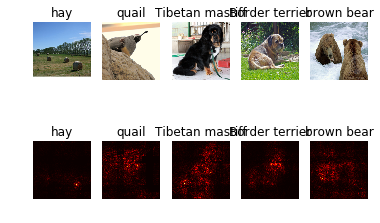

In [59]:
def compute_saliency_maps(sess, model, X, Y):
    """ Compute a class saliency map using the model for images X and labels Y """
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    feed_dict = {
        model.inputs: X,
        model.targets: Y,
    }
    """
    model.outputs[np.arange(len(Y)), Y] :== tf.gather_nd(model.outputs, tf.stack(tf.range(Y.shape[0]), Y, axis=1))
    """
    index = tf.stack([tf.range(len(Y)), model.targets], axis=1)
    derivatives = tf.gather_nd(model.outputs, index)
    image_gradients = tf.gradients(derivatives, model.inputs)[0] # gradients
    absolute = tf.abs(image_gradients) # absolute
    channel_max = tf.reduce_max(absolute, axis=3) # channel-wise max
    saliency = sess.run(channel_max, feed_dict=feed_dict)
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

SaliencyMaps = compute_saliency_maps(sess, model, X, Y)
print(X.shape, Y.shape, SaliencyMaps.shape)
plot_images(X, Y, Class_names, SaliencyMaps=SaliencyMaps)

## <a name="2"></a> 2. Visualizing class representative images ( 10 points )

In this section, you will visualize class representative images from the pretrained model (Section 2 of [4] and [7]).

By starting with a random noise image and performing gradient ascent on a target class, you can generate an **class representative image** in terms of the CNN class scoring model. More formally, let $S_c(I)$ be the unnormalized score of the class $c$, compuuted by the CNN model for an image $I$. Generate an image $I^*$ with regularizer $R(I)$ that achieves a high score for the class $y$ by solving the problem:

$$
I^* = \arg\max_I s_y(I) - R(I)
$$

In this assignment, you will use  **L2 regularization** suggested by [4] and periodic **gaussian blur** regularization suggested by [7].

**Complete** the implemeation of the `compute_class_representative_image` function and visualize some classes.

In [ ]:
def compute_class_representative_image(sess, model, target_y):
    """ Compute a class representative image using the model for target class y """
    #Training parameters
    l2_reg = 1e-3
    learning_rate =  25
    num_iterations = 100
    blur_every = 10
    show_every = 25
    max_jitter = 16

    # Generate a random noise image: 
    # Numpy array of shape (Num_iterations, H, W, 3) for saving intermediate images
    X = random_noise_image(num_iterations+1)
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    pass
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    
    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = jitter_image(X[t:t+1], ox, oy)
        
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        pass
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################    

        # Unjitter and clip the image
        Xi = unjitter_image(Xi, ox, oy)
        
        # Blur preriodically
        if t % blur_every == 0:
            Xi = blur_image(Xi, sigma=0.5)

        # Save intermediate images
        X[t+1] = Xi
           
    return X
  
target_y = 76 # Tarantula
# target_y = 78 # Tick
# target_y = 187 # Yorkshire Terrier
# target_y = 683 # Oboe
# target_y = 366 # Gorilla
# target_y = 604 # Hourglass
# target_y = np.random.randint(1000)
CR = compute_class_representative_image(sess, model, target_y)
plot_images(CR, target_y, Class_names, ClassRepresentatve=True)

## <a name="3"></a> 3. Generating adversarial examples ( 10 points )

In this section, you will generate adversarial examples from the pretrained model ( [5] ).

By starting with an image (cf. random noise) and performing gradient ascent on a target class, you can generate an **adversarial exapmle** in terms of the CNN class scoring model. Adversarial examples cause a state-of-the-art neural network to mis-classify any input image to whatever class you choose, even though the added noises are imperceptible to humans.

In this assignment, you will use **L2 regularization** to normalize the gradients when computing an image update.

**Complete** the implemeation of the `generate_adversarial_image` function and generate some adversarial examples.

In [ ]:
def generate_adversarial_image(X, target_y, model):
    """ Generate a fooling image that is close to X, but that the model classifies as target_y. """
    #Training parameters
    learning_rate =  1
    num_iterations = 100
    
    X_adversarial = X.copy()
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    pass
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ############################################################################## 
    for i in range(num_iterations):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        pass
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################      
        print("Iteration:%d\tTarget:%d\tPred:%d" % (i, target_y, pred_y))
        
        if target_y == pred_y:
            break
            
    assert target_y == pred_y, 'The network is not fooled!'
    return X_adversarial

image_idx = 0
target_y = 6
X_adversarial = generate_adversarial_image(X[image_idx:image_idx+1], target_y, model)
plot_images(X[image_idx:image_idx+1], Y[image_idx:image_idx+1], Class_names, Adversarial=X_adversarial, Target_y=target_y)